# Lab 6

__Author: Skorik Sergey__ 

## The Task

Train at least 100 MLP models on a toy dataset. Visualize their parameter projection onto 2d-space with color corresponding to accuracy.

## Theory

*Hypothesis:* Unsupervised learning methods can help in neural architecture search ([article](https://proceedings.neurips.cc/paper/2020/hash/937936029af671cf479fa893db91cbdd-Abstract.html)). 

To test the hypothesis, it is proposed to train a large (100) number of models and look at how the unsupervised methods divide these models into classes depending on their quality.

## Experiments

### Imports

In [1]:
## JAX imports
import jax
import jax.numpy as jnp
from jax import random

import numpy as np

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training.train_state import TrainState

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## import tensorflow dataset
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

##Logging
from tqdm import tqdm
import matplotlib.pyplot as plt

## Usupervised learning methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Load data

In [2]:
class BaseConfig:
    batch_size=32
    num_classes = 10
    max_networks = 100
    pass

In [3]:
data_dir = '/tmp/tfds/'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
X_train, y_train = train_data['image'], train_data['label']
X_train = jnp.reshape(X_train, (len(X_train), num_pixels))

# Full test set
X_test, y_test = test_data['image'], test_data['label']
X_test = jnp.reshape(X_test, (len(X_test), num_pixels))

# Train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


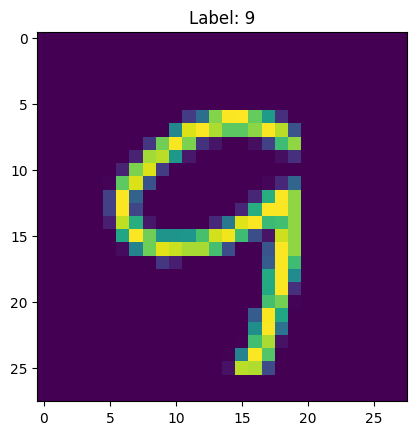

In [4]:
plt.imshow(X_train[0].reshape(28, 28))
plt.title(f"Label: {y_train[0]}")
plt.show()

### Pipeline

In [5]:
class MLP(nn.Module):
    hiddens: list

    @nn.compact
    def __call__(self, x):
        for hidden_size in self.hiddens:
            x = nn.Dense(hidden_size)(x)
            x = nn.relu(x)
        return nn.Dense(BaseConfig.num_classes)(x)

In [6]:
def create_train_state(rng, tx, hiddens):
    """Creates initial `TrainState`."""
    model = MLP(hiddens)
    params = model.init(rng, jnp.ones(shape=X_train[0].shape))['params'] # initialize parameters by passing a template input
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [7]:
@jax.jit
def loss_fn(logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=BaseConfig.num_classes)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

@jax.jit
def train_step(state, input, labels):
    def loss_f(params):
        logits = state.apply_fn({'params': params}, input)
        return loss_fn(logits, labels)
    grad_fn = jax.value_and_grad(loss_f)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def validate(X_val, y_val, state):
    logits = state.apply_fn({'params': state.params}, X_val)
    return loss_fn(logits, y_val)

def train_epoch(state, epoch, X_train, y_train):
    """Train for a single epoch."""
    train_loss = []
    bs = BaseConfig.batch_size
    for it in range(X_train.shape[0] // bs):
        input = X_train[it*bs:(it+1)*bs]
        labels = y_train[it*bs:(it+1)*bs]
        state, loss = train_step(state, input, labels)
        train_loss.append(loss.item())
    return state, train_loss

def train_model(X_train, y_train, X_test, y_test, state, epochs=100, epochs_no_improve=10):
    best_loss = jnp.inf
    best_model = None
    patience = 0
    train_losses = []
    for epoch in tqdm(range(epochs)):
        state, train_loss = train_epoch(state, epoch, X_train, y_train)
        validate_loss = validate(X_test, y_test, state)
        train_losses.extend(train_loss)
        if validate_loss < best_loss:
            best_loss = validate_loss
            best_model = state.params
            patience = 0
        if patience == epochs_no_improve:
            print("Early stopping")
            return best_model, train_losses, best_loss
        patience += 1
    return best_model, train_losses, best_loss

def calculate_acc(params, hidden, x, y):
    model = MLP(hidden)
    preds = nn.activation.softmax(model.apply({'params': params}, x))
    ids = jnp.argmax(preds, axis=-1)
    return jnp.mean(ids == y)


def flat_params(params, num_layers):
    flattened_params = jnp.array([])
    num_layers.insert(0, 784)
    num_layers.append(10)
    for i in range(len(num_layers)-1):
        weight = params[f'Dense_{i}']['kernel'].reshape(num_layers[i]*num_layers[i+1])
        bias = params[f'Dense_{i}']['bias']
        flattened_params = jnp.concatenate((flattened_params, weight))
        flattened_params = jnp.concatenate((flattened_params, bias))
    return flattened_params

def training_procedure(num_networks, hiddens, X_train, y_train, X_val, y_val, X_test, y_test):
    # train_losses = []
    val_losses = []
    test_accs = []
    params = []

    for i in range(num_networks):
        print(f"Model {i}:")
        ids = np.random.choice(X_train.shape[0], size=(X_train.shape[0]))
        state = create_train_state(random.PRNGKey(i+3), optax.adam(1e-3), hiddens[i])
        best_params, train_loss, val_loss = train_model(X_train[ids], y_train[ids], X_val, y_val, state)
        test_acc = calculate_acc(best_params, hiddens[i], X_test, y_test)
        print('Model: %d best_loss: %.4f test_acc: %.4f' % (i, val_loss, test_acc))
        params.append(flat_params(best_params, hiddens[i]))
        # train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_accs.append(test_acc)
        print("-----------------------------")

    return val_losses, test_accs, params

In [8]:
def plot_params_projection(params_projection, figtitle):
    plt.figure(figsize=(10,6))
    plt.scatter(x = params_projection[:,0], 
                y = params_projection[:, 1], 
                c = test_accs)
    plt.xlabel('x-dim', fontsize=14)
    plt.ylabel('y-dim', fontsize=14)
    plt.title(figtitle, fontsize=16)
    plt.colorbar()
    plt.plot()

#### Experiment 1: simple MLP's training

__training__

In [9]:
hiddens = [[128] for _ in range(BaseConfig.max_networks)]

val_losses, test_accs, params = training_procedure(BaseConfig.max_networks, hiddens, X_train, y_train, X_val, y_val, X_test, y_test)

Model 0:


 16%|█▌        | 16/100 [00:22<01:59,  1.42s/it]

Early stopping


Model: 0 best_loss: 0.3469 test_acc: 0.9452
-----------------------------
Model 1:


 13%|█▎        | 13/100 [00:18<02:01,  1.40s/it]


Early stopping
Model: 1 best_loss: 0.2688 test_acc: 0.9459
-----------------------------
Model 2:


 14%|█▍        | 14/100 [00:20<02:04,  1.44s/it]


Early stopping
Model: 2 best_loss: 0.3212 test_acc: 0.9366
-----------------------------
Model 3:


 15%|█▌        | 15/100 [00:20<01:56,  1.37s/it]


Early stopping
Model: 3 best_loss: 0.3075 test_acc: 0.9397
-----------------------------
Model 4:


 12%|█▏        | 12/100 [00:16<02:02,  1.39s/it]


Early stopping
Model: 4 best_loss: 0.3144 test_acc: 0.9362
-----------------------------
Model 5:


 14%|█▍        | 14/100 [00:19<02:00,  1.40s/it]


Early stopping
Model: 5 best_loss: 0.3058 test_acc: 0.9411
-----------------------------
Model 6:


 13%|█▎        | 13/100 [00:18<02:02,  1.41s/it]


Early stopping
Model: 6 best_loss: 0.3056 test_acc: 0.9428
-----------------------------
Model 7:


 14%|█▍        | 14/100 [00:19<01:58,  1.38s/it]


Early stopping
Model: 7 best_loss: 0.3188 test_acc: 0.9388
-----------------------------
Model 8:


 14%|█▍        | 14/100 [00:19<02:01,  1.41s/it]


Early stopping
Model: 8 best_loss: 0.2944 test_acc: 0.9426
-----------------------------
Model 9:


 12%|█▏        | 12/100 [00:16<02:00,  1.37s/it]


Early stopping
Model: 9 best_loss: 0.3090 test_acc: 0.9365
-----------------------------
Model 10:


 15%|█▌        | 15/100 [00:20<01:56,  1.37s/it]


Early stopping
Model: 10 best_loss: 0.3086 test_acc: 0.9481
-----------------------------
Model 11:


 12%|█▏        | 12/100 [00:20<02:27,  1.68s/it]


Early stopping
Model: 11 best_loss: 0.3148 test_acc: 0.9352
-----------------------------
Model 12:


 13%|█▎        | 13/100 [00:18<02:01,  1.40s/it]


Early stopping
Model: 12 best_loss: 0.3324 test_acc: 0.9319
-----------------------------
Model 13:


 14%|█▍        | 14/100 [00:19<01:57,  1.37s/it]


Early stopping
Model: 13 best_loss: 0.3059 test_acc: 0.9445
-----------------------------
Model 14:


 12%|█▏        | 12/100 [00:16<02:04,  1.41s/it]


Early stopping
Model: 14 best_loss: 0.2905 test_acc: 0.9404
-----------------------------
Model 15:


 12%|█▏        | 12/100 [00:16<02:01,  1.38s/it]


Early stopping
Model: 15 best_loss: 0.3141 test_acc: 0.9320
-----------------------------
Model 16:


 15%|█▌        | 15/100 [00:20<01:58,  1.39s/it]


Early stopping
Model: 16 best_loss: 0.3235 test_acc: 0.9422
-----------------------------
Model 17:


 11%|█         | 11/100 [00:15<02:04,  1.40s/it]


Early stopping
Model: 17 best_loss: 0.3234 test_acc: 0.9300
-----------------------------
Model 18:


 12%|█▏        | 12/100 [00:17<02:05,  1.42s/it]


Early stopping
Model: 18 best_loss: 0.3221 test_acc: 0.9346
-----------------------------
Model 19:


 12%|█▏        | 12/100 [00:17<02:06,  1.44s/it]


Early stopping
Model: 19 best_loss: 0.3089 test_acc: 0.9333
-----------------------------
Model 20:


 14%|█▍        | 14/100 [00:19<01:58,  1.38s/it]


Early stopping
Model: 20 best_loss: 0.2935 test_acc: 0.9454
-----------------------------
Model 21:


 13%|█▎        | 13/100 [00:18<02:02,  1.41s/it]


Early stopping
Model: 21 best_loss: 0.3212 test_acc: 0.9399
-----------------------------
Model 22:


 14%|█▍        | 14/100 [00:19<01:59,  1.38s/it]


Early stopping
Model: 22 best_loss: 0.2783 test_acc: 0.9388
-----------------------------
Model 23:


 14%|█▍        | 14/100 [00:19<02:00,  1.40s/it]


Early stopping
Model: 23 best_loss: 0.2973 test_acc: 0.9411
-----------------------------
Model 24:


 14%|█▍        | 14/100 [00:19<01:58,  1.38s/it]


Early stopping
Model: 24 best_loss: 0.3317 test_acc: 0.9433
-----------------------------
Model 25:


 14%|█▍        | 14/100 [00:19<02:01,  1.41s/it]


Early stopping
Model: 25 best_loss: 0.3122 test_acc: 0.9417
-----------------------------
Model 26:


 13%|█▎        | 13/100 [00:18<02:03,  1.42s/it]


Early stopping
Model: 26 best_loss: 0.3193 test_acc: 0.9367
-----------------------------
Model 27:


 14%|█▍        | 14/100 [00:19<01:59,  1.39s/it]


Early stopping
Model: 27 best_loss: 0.3223 test_acc: 0.9367
-----------------------------
Model 28:


 13%|█▎        | 13/100 [00:18<02:04,  1.43s/it]


Early stopping
Model: 28 best_loss: 0.2973 test_acc: 0.9434
-----------------------------
Model 29:


 11%|█         | 11/100 [00:15<02:05,  1.41s/it]


Early stopping
Model: 29 best_loss: 0.3262 test_acc: 0.9295
-----------------------------
Model 30:


 12%|█▏        | 12/100 [00:16<02:03,  1.41s/it]


Early stopping
Model: 30 best_loss: 0.2916 test_acc: 0.9382
-----------------------------
Model 31:


 15%|█▌        | 15/100 [00:21<02:00,  1.42s/it]


Early stopping
Model: 31 best_loss: 0.3076 test_acc: 0.9396
-----------------------------
Model 32:


 14%|█▍        | 14/100 [00:19<02:01,  1.42s/it]


Early stopping
Model: 32 best_loss: 0.2979 test_acc: 0.9460
-----------------------------
Model 33:


 14%|█▍        | 14/100 [00:19<01:58,  1.38s/it]


Early stopping
Model: 33 best_loss: 0.3051 test_acc: 0.9449
-----------------------------
Model 34:


 12%|█▏        | 12/100 [00:17<02:07,  1.45s/it]


Early stopping
Model: 34 best_loss: 0.2965 test_acc: 0.9444
-----------------------------
Model 35:


 12%|█▏        | 12/100 [00:16<02:02,  1.40s/it]


Early stopping
Model: 35 best_loss: 0.2938 test_acc: 0.9400
-----------------------------
Model 36:


 15%|█▌        | 15/100 [00:21<01:59,  1.40s/it]


Early stopping
Model: 36 best_loss: 0.3234 test_acc: 0.9387
-----------------------------
Model 37:


 13%|█▎        | 13/100 [00:18<02:01,  1.40s/it]


Early stopping
Model: 37 best_loss: 0.3083 test_acc: 0.9348
-----------------------------
Model 38:


 13%|█▎        | 13/100 [00:19<02:08,  1.47s/it]


Early stopping
Model: 38 best_loss: 0.3192 test_acc: 0.9291
-----------------------------
Model 39:


 14%|█▍        | 14/100 [00:19<01:59,  1.39s/it]


Early stopping
Model: 39 best_loss: 0.3030 test_acc: 0.9417
-----------------------------
Model 40:


 14%|█▍        | 14/100 [00:20<02:03,  1.44s/it]


Early stopping
Model: 40 best_loss: 0.3178 test_acc: 0.9357
-----------------------------
Model 41:


 14%|█▍        | 14/100 [00:20<02:03,  1.44s/it]


Early stopping
Model: 41 best_loss: 0.3361 test_acc: 0.9449
-----------------------------
Model 42:


 12%|█▏        | 12/100 [00:17<02:06,  1.44s/it]


Early stopping
Model: 42 best_loss: 0.2967 test_acc: 0.9337
-----------------------------
Model 43:


 16%|█▌        | 16/100 [00:22<01:57,  1.40s/it]


Early stopping
Model: 43 best_loss: 0.3308 test_acc: 0.9486
-----------------------------
Model 44:


 12%|█▏        | 12/100 [00:17<02:05,  1.43s/it]


Early stopping
Model: 44 best_loss: 0.3362 test_acc: 0.9356
-----------------------------
Model 45:


 12%|█▏        | 12/100 [00:17<02:08,  1.46s/it]


Early stopping
Model: 45 best_loss: 0.3321 test_acc: 0.9252
-----------------------------
Model 46:


 17%|█▋        | 17/100 [00:23<01:56,  1.40s/it]


Early stopping
Model: 46 best_loss: 0.3271 test_acc: 0.9402
-----------------------------
Model 47:


 13%|█▎        | 13/100 [00:18<02:03,  1.42s/it]


Early stopping
Model: 47 best_loss: 0.3282 test_acc: 0.9379
-----------------------------
Model 48:


 12%|█▏        | 12/100 [00:17<02:07,  1.45s/it]


Early stopping
Model: 48 best_loss: 0.2949 test_acc: 0.9308
-----------------------------
Model 49:


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]


Early stopping
Model: 49 best_loss: 0.3210 test_acc: 0.9302
-----------------------------
Model 50:


 13%|█▎        | 13/100 [00:18<02:05,  1.44s/it]


Early stopping
Model: 50 best_loss: 0.3467 test_acc: 0.9346
-----------------------------
Model 51:


 14%|█▍        | 14/100 [00:20<02:05,  1.46s/it]


Early stopping
Model: 51 best_loss: 0.2744 test_acc: 0.9430
-----------------------------
Model 52:


 15%|█▌        | 15/100 [00:21<02:02,  1.44s/it]


Early stopping
Model: 52 best_loss: 0.3331 test_acc: 0.9367
-----------------------------
Model 53:


 16%|█▌        | 16/100 [00:22<01:59,  1.42s/it]


Early stopping
Model: 53 best_loss: 0.3334 test_acc: 0.9456
-----------------------------
Model 54:


 14%|█▍        | 14/100 [00:20<02:02,  1.43s/it]


Early stopping
Model: 54 best_loss: 0.3209 test_acc: 0.9393
-----------------------------
Model 55:


 14%|█▍        | 14/100 [00:20<02:04,  1.44s/it]


Early stopping
Model: 55 best_loss: 0.3162 test_acc: 0.9469
-----------------------------
Model 56:


 15%|█▌        | 15/100 [00:21<02:01,  1.42s/it]


Early stopping
Model: 56 best_loss: 0.3239 test_acc: 0.9404
-----------------------------
Model 57:


 12%|█▏        | 12/100 [00:17<02:06,  1.44s/it]


Early stopping
Model: 57 best_loss: 0.3132 test_acc: 0.9300
-----------------------------
Model 58:


 12%|█▏        | 12/100 [00:17<02:09,  1.47s/it]


Early stopping
Model: 58 best_loss: 0.2955 test_acc: 0.9364
-----------------------------
Model 59:


 13%|█▎        | 13/100 [00:18<02:04,  1.43s/it]


Early stopping
Model: 59 best_loss: 0.3420 test_acc: 0.9443
-----------------------------
Model 60:


 11%|█         | 11/100 [00:16<02:10,  1.47s/it]


Early stopping
Model: 60 best_loss: 0.3136 test_acc: 0.9410
-----------------------------
Model 61:


 17%|█▋        | 17/100 [00:24<01:58,  1.43s/it]


Early stopping
Model: 61 best_loss: 0.3442 test_acc: 0.9451
-----------------------------
Model 62:


 12%|█▏        | 12/100 [00:18<02:13,  1.51s/it]


Early stopping
Model: 62 best_loss: 0.3365 test_acc: 0.9339
-----------------------------
Model 63:


 13%|█▎        | 13/100 [00:19<02:07,  1.46s/it]


Early stopping
Model: 63 best_loss: 0.3284 test_acc: 0.9331
-----------------------------
Model 64:


 12%|█▏        | 12/100 [00:18<02:13,  1.51s/it]


Early stopping
Model: 64 best_loss: 0.3442 test_acc: 0.9322
-----------------------------
Model 65:


 12%|█▏        | 12/100 [00:17<02:09,  1.48s/it]


Early stopping
Model: 65 best_loss: 0.3049 test_acc: 0.9347
-----------------------------
Model 66:


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]


Early stopping
Model: 66 best_loss: 0.3356 test_acc: 0.9400
-----------------------------
Model 67:


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]


Early stopping
Model: 67 best_loss: 0.3097 test_acc: 0.9386
-----------------------------
Model 68:


 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]


Early stopping
Model: 68 best_loss: 0.3073 test_acc: 0.9413
-----------------------------
Model 69:


 16%|█▌        | 16/100 [00:22<02:00,  1.44s/it]


Early stopping
Model: 69 best_loss: 0.3332 test_acc: 0.9462
-----------------------------
Model 70:


 15%|█▌        | 15/100 [00:21<02:03,  1.45s/it]


Early stopping
Model: 70 best_loss: 0.3098 test_acc: 0.9428
-----------------------------
Model 71:


 11%|█         | 11/100 [00:16<02:17,  1.54s/it]


Early stopping
Model: 71 best_loss: 0.3284 test_acc: 0.9289
-----------------------------
Model 72:


 13%|█▎        | 13/100 [00:18<02:06,  1.46s/it]


Early stopping
Model: 72 best_loss: 0.2696 test_acc: 0.9432
-----------------------------
Model 73:


 13%|█▎        | 13/100 [00:19<02:10,  1.50s/it]


Early stopping
Model: 73 best_loss: 0.3289 test_acc: 0.9277
-----------------------------
Model 74:


 14%|█▍        | 14/100 [00:20<02:06,  1.47s/it]


Early stopping
Model: 74 best_loss: 0.2959 test_acc: 0.9429
-----------------------------
Model 75:


 13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]


Early stopping
Model: 75 best_loss: 0.2618 test_acc: 0.9418
-----------------------------
Model 76:


 13%|█▎        | 13/100 [00:19<02:11,  1.51s/it]


Early stopping
Model: 76 best_loss: 0.3093 test_acc: 0.9377
-----------------------------
Model 77:


 13%|█▎        | 13/100 [00:19<02:08,  1.48s/it]


Early stopping
Model: 77 best_loss: 0.3168 test_acc: 0.9311
-----------------------------
Model 78:


 11%|█         | 11/100 [00:17<02:22,  1.60s/it]


Early stopping
Model: 78 best_loss: 0.3245 test_acc: 0.9289
-----------------------------
Model 79:


 12%|█▏        | 12/100 [00:18<02:12,  1.51s/it]


Early stopping
Model: 79 best_loss: 0.3198 test_acc: 0.9312
-----------------------------
Model 80:


 12%|█▏        | 12/100 [00:18<02:15,  1.54s/it]


Early stopping
Model: 80 best_loss: 0.3427 test_acc: 0.9387
-----------------------------
Model 81:


 12%|█▏        | 12/100 [00:17<02:11,  1.50s/it]


Early stopping
Model: 81 best_loss: 0.3149 test_acc: 0.9371
-----------------------------
Model 82:


 12%|█▏        | 12/100 [00:18<02:14,  1.53s/it]


Early stopping
Model: 82 best_loss: 0.3248 test_acc: 0.9281
-----------------------------
Model 83:


 15%|█▌        | 15/100 [00:21<02:04,  1.46s/it]


Early stopping
Model: 83 best_loss: 0.3002 test_acc: 0.9349
-----------------------------
Model 84:


 13%|█▎        | 13/100 [00:19<02:10,  1.50s/it]


Early stopping
Model: 84 best_loss: 0.3255 test_acc: 0.9385
-----------------------------
Model 85:


 14%|█▍        | 14/100 [00:20<02:07,  1.49s/it]


Early stopping
Model: 85 best_loss: 0.2616 test_acc: 0.9384
-----------------------------
Model 86:


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]


Early stopping
Model: 86 best_loss: 0.3226 test_acc: 0.9369
-----------------------------
Model 87:


 12%|█▏        | 12/100 [00:17<02:10,  1.49s/it]


Early stopping
Model: 87 best_loss: 0.3454 test_acc: 0.9320
-----------------------------
Model 88:


 14%|█▍        | 14/100 [00:20<02:08,  1.49s/it]


Early stopping
Model: 88 best_loss: 0.3148 test_acc: 0.9342
-----------------------------
Model 89:


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]


Early stopping
Model: 89 best_loss: 0.2971 test_acc: 0.9483
-----------------------------
Model 90:


 14%|█▍        | 14/100 [00:20<02:05,  1.46s/it]


Early stopping
Model: 90 best_loss: 0.3338 test_acc: 0.9402
-----------------------------
Model 91:


 16%|█▌        | 16/100 [00:23<02:05,  1.49s/it]


Early stopping
Model: 91 best_loss: 0.3419 test_acc: 0.9520
-----------------------------
Model 92:


 14%|█▍        | 14/100 [00:21<02:10,  1.51s/it]


Early stopping
Model: 92 best_loss: 0.3015 test_acc: 0.9433
-----------------------------
Model 93:


 14%|█▍        | 14/100 [00:21<02:10,  1.52s/it]


Early stopping
Model: 93 best_loss: 0.3212 test_acc: 0.9377
-----------------------------
Model 94:


 16%|█▌        | 16/100 [00:23<02:05,  1.49s/it]


Early stopping
Model: 94 best_loss: 0.3007 test_acc: 0.9455
-----------------------------
Model 95:


 14%|█▍        | 14/100 [00:20<02:07,  1.49s/it]


Early stopping
Model: 95 best_loss: 0.3233 test_acc: 0.9381
-----------------------------
Model 96:


 12%|█▏        | 12/100 [00:18<02:16,  1.55s/it]


Early stopping
Model: 96 best_loss: 0.3064 test_acc: 0.9321
-----------------------------
Model 97:


 14%|█▍        | 14/100 [00:21<02:10,  1.52s/it]


Early stopping
Model: 97 best_loss: 0.3190 test_acc: 0.9448
-----------------------------
Model 98:


 14%|█▍        | 14/100 [00:20<02:07,  1.49s/it]


Early stopping
Model: 98 best_loss: 0.3097 test_acc: 0.9386
-----------------------------
Model 99:


 12%|█▏        | 12/100 [00:18<02:18,  1.57s/it]

Early stopping
Model: 99 best_loss: 0.3213 test_acc: 0.9311
-----------------------------


__parameter projection__

In [12]:
np.array(params).shape

(100, 101770)

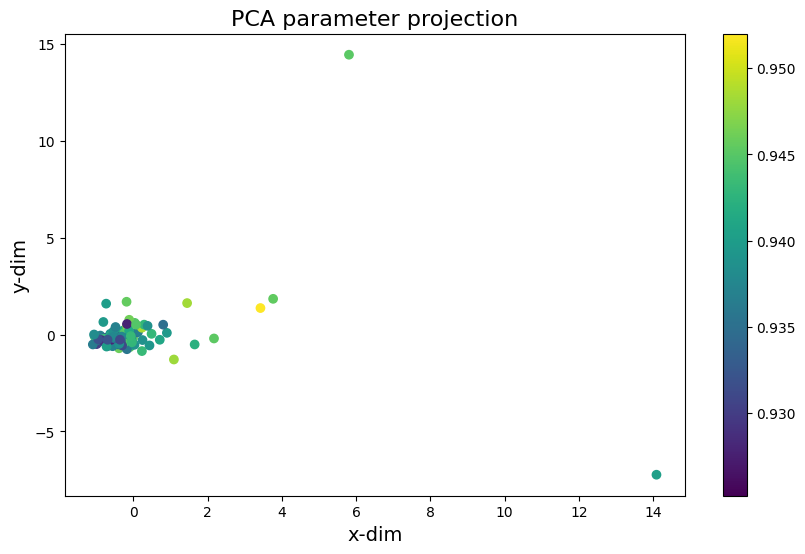

In [11]:
pca = PCA(2)
params_projection = pca.fit_transform(np.array(params))
plot_params_projection(params_projection, 'PCA parameter projection')

__According to sklearn tsne reccomendation, we preliminary reduce vector dimension to 50 number of features__

In [13]:
pca = PCA(50)
tsne = TSNE()
reduce_params = pca.fit_transform(np.array(params))
params_projection = tsne.fit_transform(reduce_params)

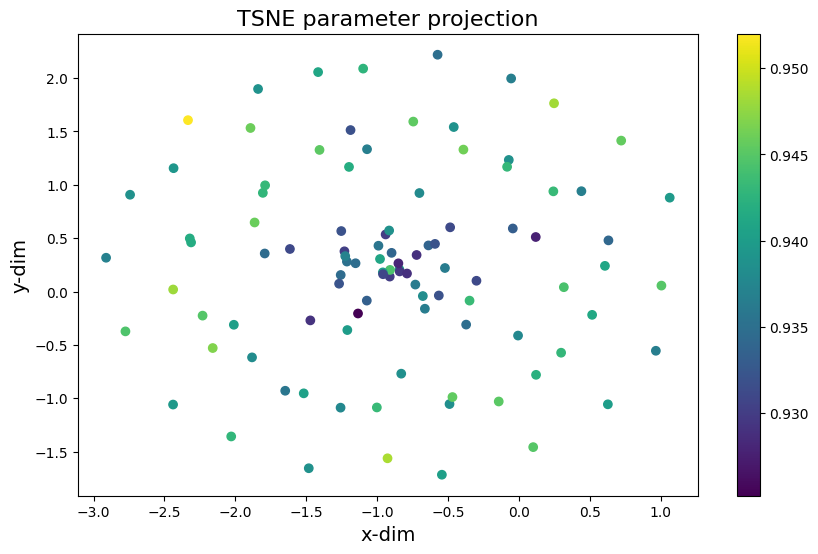

In [14]:
plot_params_projection(params_projection, 'TSNE parameter projection')

#### Experiment 2: latent space variation

In [ ]:
hiddens = []

hiddens_1 = random.randint(random.PRNGKey(0), shape=(33, ), minval=128, maxval=257)
hiddens_1 = [[int(h), 32] for h in hiddens_1]

hiddens_2_1 = random.randint(random.PRNGKey(1), shape=(34, ), minval=256, maxval=500)
hiddens_2_2 = random.randint(random.PRNGKey(1), shape=(34, ), minval=128, maxval=256)
hiddens_2 = [[h1, h2, 32] for h1, h2 in zip(hiddens_2_1, hiddens_2_2)]

hiddens_3_1 = random.randint(random.PRNGKey(2), shape=(33, ), minval=256, maxval=500)
hiddens_3_2 = random.randint(random.PRNGKey(2), shape=(33, ), minval=128, maxval=256)
hiddens_3_3 = random.randint(random.PRNGKey(2), shape=(33, ), minval=64, maxval=128)
hiddens_3 = [[h1, h2, h3, 32] for h1, h2, h3 in zip(hiddens_3_1, hiddens_3_2, hiddens_3_3)]

hiddens.extend(hiddens_1)
hiddens.extend(hiddens_2)
hiddens.extend(hiddens_3)

print(len(hiddens))

100


__training__

In [ ]:
val_losses, test_accs, params = training_procedure(BaseConfig.max_networks, hiddens, X_train, y_train, X_val, y_val, X_test, y_test)

Model 0:


 18%|█▊        | 18/100 [00:28<02:07,  1.56s/it]

Early stopping


Model: 0 best_loss: 0.1949 test_acc: 0.9625
-----------------------------
Model 1:


 12%|█▏        | 12/100 [00:18<02:18,  1.57s/it]

Early stopping


Model: 1 best_loss: 0.2577 test_acc: 0.9418
-----------------------------
Model 2:


 19%|█▉        | 19/100 [00:27<01:58,  1.47s/it]

Early stopping


Model: 2 best_loss: 0.1941 test_acc: 0.9674
-----------------------------
Model 3:


 17%|█▋        | 17/100 [00:25<02:04,  1.50s/it]

Early stopping


Model: 3 best_loss: 0.1934 test_acc: 0.9600
-----------------------------
Model 4:


 19%|█▉        | 19/100 [00:29<02:05,  1.54s/it]

Early stopping


Model: 4 best_loss: 0.1924 test_acc: 0.9648
-----------------------------
Model 5:


 15%|█▌        | 15/100 [00:22<02:09,  1.52s/it]

Early stopping


Model: 5 best_loss: 0.2001 test_acc: 0.9568
-----------------------------
Model 6:


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

Early stopping


Model: 6 best_loss: 0.2047 test_acc: 0.9631
-----------------------------
Model 7:


 17%|█▋        | 17/100 [00:24<02:01,  1.47s/it]

Early stopping


Model: 7 best_loss: 0.1803 test_acc: 0.9626
-----------------------------
Model 8:


 18%|█▊        | 18/100 [00:26<02:00,  1.47s/it]

Early stopping


Model: 8 best_loss: 0.2117 test_acc: 0.9604
-----------------------------
Model 9:


 16%|█▌        | 16/100 [00:23<02:05,  1.50s/it]

Early stopping


Model: 9 best_loss: 0.1965 test_acc: 0.9572
-----------------------------
Model 10:


 17%|█▋        | 17/100 [00:25<02:04,  1.50s/it]

Early stopping


Model: 10 best_loss: 0.2111 test_acc: 0.9652
-----------------------------
Model 11:


 16%|█▌        | 16/100 [00:24<02:07,  1.52s/it]

Early stopping


Model: 11 best_loss: 0.2021 test_acc: 0.9594
-----------------------------
Model 12:


 14%|█▍        | 14/100 [00:21<02:11,  1.53s/it]

Early stopping


Model: 12 best_loss: 0.1859 test_acc: 0.9605
-----------------------------
Model 13:


 13%|█▎        | 13/100 [00:18<02:06,  1.45s/it]


Early stopping
Model: 13 best_loss: 0.2080 test_acc: 0.9512
-----------------------------
Model 14:


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]


Early stopping
Model: 14 best_loss: 0.1970 test_acc: 0.9610
-----------------------------
Model 15:


 15%|█▌        | 15/100 [00:22<02:05,  1.48s/it]

Early stopping
Model: 15 best_loss: 0.1962 test_acc: 0.9582
-----------------------------
Model 16:



 15%|█▌        | 15/100 [00:22<02:08,  1.52s/it]

Early stopping


Model: 16 best_loss: 0.1883 test_acc: 0.9635
-----------------------------
Model 17:


 13%|█▎        | 13/100 [00:20<02:14,  1.55s/it]

Early stopping


Model: 17 best_loss: 0.1946 test_acc: 0.9563
-----------------------------
Model 18:


 15%|█▌        | 15/100 [00:23<02:12,  1.56s/it]

Early stopping


Model: 18 best_loss: 0.2077 test_acc: 0.9543
-----------------------------
Model 19:


 13%|█▎        | 13/100 [00:20<02:15,  1.56s/it]

Early stopping


Model: 19 best_loss: 0.2109 test_acc: 0.9508
-----------------------------
Model 20:


 16%|█▌        | 16/100 [00:23<02:04,  1.48s/it]

Early stopping


Model: 20 best_loss: 0.1797 test_acc: 0.9615
-----------------------------
Model 21:


 14%|█▍        | 14/100 [00:20<02:08,  1.49s/it]

Early stopping


Model: 21 best_loss: 0.1884 test_acc: 0.9578
-----------------------------
Model 22:


 15%|█▌        | 15/100 [00:22<02:05,  1.47s/it]

Early stopping


Model: 22 best_loss: 0.2023 test_acc: 0.9589
-----------------------------
Model 23:


 15%|█▌        | 15/100 [00:22<02:06,  1.49s/it]


Early stopping
Model: 23 best_loss: 0.1968 test_acc: 0.9544
-----------------------------
Model 24:


 17%|█▋        | 17/100 [00:24<02:01,  1.46s/it]


Early stopping
Model: 24 best_loss: 0.2120 test_acc: 0.9626
-----------------------------
Model 25:


 15%|█▌        | 15/100 [00:22<02:06,  1.49s/it]


Early stopping
Model: 25 best_loss: 0.2012 test_acc: 0.9576
-----------------------------
Model 26:


 16%|█▌        | 16/100 [00:23<02:03,  1.47s/it]

Early stopping
Model: 26 best_loss: 0.1940 test_acc: 0.9606
-----------------------------
Model 27:



 17%|█▋        | 17/100 [00:24<02:01,  1.47s/it]

Early stopping


Model: 27 best_loss: 0.2007 test_acc: 0.9613
-----------------------------
Model 28:


 15%|█▌        | 15/100 [00:22<02:07,  1.50s/it]

Early stopping
Model: 28 best_loss: 0.1852 test_acc: 0.9584
-----------------------------
Model 29:



 16%|█▌        | 16/100 [00:24<02:08,  1.53s/it]

Early stopping


Model: 29 best_loss: 0.2255 test_acc: 0.9589
-----------------------------
Model 30:


 15%|█▌        | 15/100 [00:22<02:10,  1.53s/it]

Early stopping


Model: 30 best_loss: 0.1872 test_acc: 0.9606
-----------------------------
Model 31:


 16%|█▌        | 16/100 [00:24<02:06,  1.51s/it]

Early stopping


Model: 31 best_loss: 0.1688 test_acc: 0.9609
-----------------------------
Model 32:


 17%|█▋        | 17/100 [00:25<02:03,  1.49s/it]

Early stopping


Model: 32 best_loss: 0.1803 test_acc: 0.9640
-----------------------------
Model 33:


 21%|██        | 21/100 [00:31<02:00,  1.52s/it]

Early stopping


Model: 33 best_loss: 0.1725 test_acc: 0.9711
-----------------------------
Model 34:


 15%|█▌        | 15/100 [00:23<02:12,  1.56s/it]

Early stopping


Model: 34 best_loss: 0.1506 test_acc: 0.9678
-----------------------------
Model 35:


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

Early stopping


Model: 35 best_loss: 0.1747 test_acc: 0.9623
-----------------------------
Model 36:


 14%|█▍        | 14/100 [00:22<02:19,  1.62s/it]

Early stopping


Model: 36 best_loss: 0.1780 test_acc: 0.9631
-----------------------------
Model 37:


 15%|█▌        | 15/100 [00:24<02:17,  1.61s/it]

Early stopping


Model: 37 best_loss: 0.1838 test_acc: 0.9621
-----------------------------
Model 38:


 13%|█▎        | 13/100 [00:20<02:19,  1.61s/it]

Early stopping


Model: 38 best_loss: 0.1577 test_acc: 0.9588
-----------------------------
Model 39:


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

Early stopping


Model: 39 best_loss: 0.1485 test_acc: 0.9661
-----------------------------
Model 40:


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

Early stopping


Model: 40 best_loss: 0.1560 test_acc: 0.9694
-----------------------------
Model 41:


 14%|█▍        | 14/100 [00:22<02:21,  1.64s/it]

Early stopping


Model: 41 best_loss: 0.1540 test_acc: 0.9667
-----------------------------
Model 42:


 12%|█▏        | 12/100 [00:20<02:27,  1.67s/it]

Early stopping


Model: 42 best_loss: 0.1747 test_acc: 0.9583
-----------------------------
Model 43:


 13%|█▎        | 13/100 [00:20<02:17,  1.58s/it]

Early stopping


Model: 43 best_loss: 0.1762 test_acc: 0.9612
-----------------------------
Model 44:


 15%|█▌        | 15/100 [00:24<02:18,  1.63s/it]

Early stopping


Model: 44 best_loss: 0.1560 test_acc: 0.9671
-----------------------------
Model 45:


 16%|█▌        | 16/100 [00:26<02:18,  1.64s/it]

Early stopping


Model: 45 best_loss: 0.1698 test_acc: 0.9689
-----------------------------
Model 46:


 14%|█▍        | 14/100 [00:22<02:18,  1.61s/it]

Early stopping


Model: 46 best_loss: 0.2099 test_acc: 0.9591
-----------------------------
Model 47:


 15%|█▌        | 15/100 [00:23<02:12,  1.55s/it]

Early stopping
Model: 47 best_loss: 0.1476 test_acc: 0.9670
-----------------------------
Model 48:



 15%|█▌        | 15/100 [00:23<02:15,  1.60s/it]

Early stopping


Model: 48 best_loss: 0.1695 test_acc: 0.9640
-----------------------------
Model 49:


 14%|█▍        | 14/100 [00:22<02:17,  1.60s/it]

Early stopping


Model: 49 best_loss: 0.1731 test_acc: 0.9623
-----------------------------
Model 50:


 16%|█▌        | 16/100 [00:25<02:14,  1.61s/it]

Early stopping


Model: 50 best_loss: 0.1697 test_acc: 0.9659
-----------------------------
Model 51:


 19%|█▉        | 19/100 [00:29<02:06,  1.56s/it]

Early stopping


Model: 51 best_loss: 0.2347 test_acc: 0.9501
-----------------------------
Model 52:


 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]

Early stopping


Model: 52 best_loss: 0.1590 test_acc: 0.9654
-----------------------------
Model 53:


 14%|█▍        | 14/100 [00:22<02:20,  1.64s/it]

Early stopping


Model: 53 best_loss: 0.1632 test_acc: 0.9612
-----------------------------
Model 54:


 17%|█▋        | 17/100 [00:27<02:12,  1.60s/it]

Early stopping


Model: 54 best_loss: 0.1491 test_acc: 0.9676
-----------------------------
Model 55:


 16%|█▌        | 16/100 [00:24<02:10,  1.55s/it]

Early stopping


Model: 55 best_loss: 0.1651 test_acc: 0.9689
-----------------------------
Model 56:


 12%|█▏        | 12/100 [00:19<02:25,  1.66s/it]

Early stopping


Model: 56 best_loss: 0.1735 test_acc: 0.9622
-----------------------------
Model 57:


 14%|█▍        | 14/100 [00:22<02:20,  1.64s/it]

Early stopping


Model: 57 best_loss: 0.1497 test_acc: 0.9671
-----------------------------
Model 58:


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

Early stopping


Model: 58 best_loss: 0.1766 test_acc: 0.9609
-----------------------------
Model 59:


 14%|█▍        | 14/100 [00:22<02:17,  1.59s/it]

Early stopping
Model: 59 best_loss: 0.1510 test_acc: 0.9653
-----------------------------
Model 60:



 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]

Early stopping


Model: 60 best_loss: 0.1628 test_acc: 0.9670
-----------------------------
Model 61:


 14%|█▍        | 14/100 [00:22<02:20,  1.63s/it]

Early stopping


Model: 61 best_loss: 0.1528 test_acc: 0.9671
-----------------------------
Model 62:


 15%|█▌        | 15/100 [00:24<02:16,  1.61s/it]

Early stopping


Model: 62 best_loss: 0.1613 test_acc: 0.9687
-----------------------------
Model 63:


 20%|██        | 20/100 [00:30<02:02,  1.53s/it]

Early stopping


Model: 63 best_loss: 0.1779 test_acc: 0.9678
-----------------------------
Model 64:


 15%|█▌        | 15/100 [00:22<02:09,  1.53s/it]

Early stopping


Model: 64 best_loss: 0.1645 test_acc: 0.9648
-----------------------------
Model 65:


 16%|█▌        | 16/100 [00:25<02:14,  1.61s/it]

Early stopping


Model: 65 best_loss: 0.1691 test_acc: 0.9691
-----------------------------
Model 66:


 15%|█▌        | 15/100 [00:24<02:16,  1.60s/it]

Early stopping


Model: 66 best_loss: 0.1584 test_acc: 0.9696
-----------------------------
Model 67:


 17%|█▋        | 17/100 [00:30<02:29,  1.80s/it]

Early stopping


Model: 67 best_loss: 0.1404 test_acc: 0.9685
-----------------------------
Model 68:


 13%|█▎        | 13/100 [00:23<02:37,  1.81s/it]

Early stopping


Model: 68 best_loss: 0.1681 test_acc: 0.9607
-----------------------------
Model 69:


 26%|██▌       | 26/100 [00:42<02:02,  1.65s/it]

Early stopping


Model: 69 best_loss: 0.1537 test_acc: 0.9774
-----------------------------
Model 70:


 17%|█▋        | 17/100 [00:28<02:18,  1.67s/it]

Early stopping


Model: 70 best_loss: 0.1577 test_acc: 0.9684
-----------------------------
Model 71:


 20%|██        | 20/100 [00:34<02:17,  1.72s/it]

Early stopping


Model: 71 best_loss: 0.1416 test_acc: 0.9711
-----------------------------
Model 72:


 20%|██        | 20/100 [00:34<02:18,  1.73s/it]

Early stopping


Model: 72 best_loss: 0.1659 test_acc: 0.9644
-----------------------------
Model 73:


 16%|█▌        | 16/100 [00:28<02:29,  1.79s/it]

Early stopping


Model: 73 best_loss: 0.1539 test_acc: 0.9700
-----------------------------
Model 74:


 19%|█▉        | 19/100 [00:33<02:21,  1.75s/it]

Early stopping


Model: 74 best_loss: 0.1418 test_acc: 0.9711
-----------------------------
Model 75:


 16%|█▌        | 16/100 [00:28<02:29,  1.78s/it]

Early stopping


Model: 75 best_loss: 0.1433 test_acc: 0.9713
-----------------------------
Model 76:


 21%|██        | 21/100 [00:35<02:13,  1.69s/it]

Early stopping


Model: 76 best_loss: 0.1572 test_acc: 0.9728
-----------------------------
Model 77:


 17%|█▋        | 17/100 [00:29<02:24,  1.74s/it]

Early stopping


Model: 77 best_loss: 0.1502 test_acc: 0.9697
-----------------------------
Model 78:


 16%|█▌        | 16/100 [00:29<02:32,  1.81s/it]

Early stopping


Model: 78 best_loss: 0.1645 test_acc: 0.9715
-----------------------------
Model 79:


 24%|██▍       | 24/100 [00:39<02:05,  1.65s/it]

Early stopping


Model: 79 best_loss: 0.1713 test_acc: 0.9730
-----------------------------
Model 80:


 13%|█▎        | 13/100 [00:23<02:40,  1.84s/it]

Early stopping


Model: 80 best_loss: 0.1636 test_acc: 0.9615
-----------------------------
Model 81:


 14%|█▍        | 14/100 [00:25<02:37,  1.83s/it]

Early stopping


Model: 81 best_loss: 0.1497 test_acc: 0.9670
-----------------------------
Model 82:


 14%|█▍        | 14/100 [00:24<02:30,  1.76s/it]

Early stopping


Model: 82 best_loss: 0.1596 test_acc: 0.9652
-----------------------------
Model 83:


 17%|█▋        | 17/100 [00:29<02:25,  1.75s/it]

Early stopping


Model: 83 best_loss: 0.1422 test_acc: 0.9690
-----------------------------
Model 84:


 17%|█▋        | 17/100 [00:29<02:22,  1.72s/it]

Early stopping


Model: 84 best_loss: 0.1612 test_acc: 0.9697
-----------------------------
Model 85:


 15%|█▌        | 15/100 [00:26<02:28,  1.74s/it]

Early stopping


Model: 85 best_loss: 0.1550 test_acc: 0.9676
-----------------------------
Model 86:


 18%|█▊        | 18/100 [00:31<02:23,  1.75s/it]

Early stopping


Model: 86 best_loss: 0.1484 test_acc: 0.9708
-----------------------------
Model 87:


 14%|█▍        | 14/100 [00:25<02:34,  1.80s/it]

Early stopping


Model: 87 best_loss: 0.1429 test_acc: 0.9675
-----------------------------
Model 88:


 16%|█▌        | 16/100 [00:28<02:28,  1.77s/it]

Early stopping


Model: 88 best_loss: 0.1513 test_acc: 0.9674
-----------------------------
Model 89:


 17%|█▋        | 17/100 [00:29<02:25,  1.75s/it]

Early stopping


Model: 89 best_loss: 0.1410 test_acc: 0.9708
-----------------------------
Model 90:


 21%|██        | 21/100 [00:36<02:16,  1.73s/it]

Early stopping


Model: 90 best_loss: 0.1593 test_acc: 0.9726
-----------------------------
Model 91:


 15%|█▌        | 15/100 [00:26<02:32,  1.80s/it]

Early stopping


Model: 91 best_loss: 0.1513 test_acc: 0.9682
-----------------------------
Model 92:


 18%|█▊        | 18/100 [00:31<02:24,  1.76s/it]

Early stopping


Model: 92 best_loss: 0.1649 test_acc: 0.9684
-----------------------------
Model 93:


 12%|█▏        | 12/100 [00:22<02:44,  1.87s/it]

Early stopping


Model: 93 best_loss: 0.1512 test_acc: 0.9618
-----------------------------
Model 94:


 20%|██        | 20/100 [00:33<02:15,  1.69s/it]

Early stopping


Model: 94 best_loss: 0.1500 test_acc: 0.9700
-----------------------------
Model 95:


 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

Early stopping


Model: 95 best_loss: 0.1645 test_acc: 0.9650
-----------------------------
Model 96:


 14%|█▍        | 14/100 [00:27<02:48,  1.96s/it]

Early stopping


Model: 96 best_loss: 0.1612 test_acc: 0.9640
-----------------------------
Model 97:


 19%|█▉        | 19/100 [00:39<02:47,  2.07s/it]

Early stopping


Model: 97 best_loss: 0.1366 test_acc: 0.9710
-----------------------------
Model 98:


 22%|██▏       | 22/100 [00:37<02:13,  1.71s/it]

Early stopping


Model: 98 best_loss: 0.1449 test_acc: 0.9720
-----------------------------
Model 99:


 16%|█▌        | 16/100 [00:28<02:27,  1.76s/it]

Early stopping


Model: 99 best_loss: 0.1413 test_acc: 0.9727
-----------------------------


__parameter projection__

In [ ]:
flattened_params = []

for param in params:
    flat = []
    weight = list(param[f'Dense_{len(param) - 1}']['kernel'].flatten())
    bias = list(param[f'Dense_{len(param) - 1}']['bias'].flatten())
    flat.extend(weight)
    flat.extend(bias)
    flattened_params.append(flat)

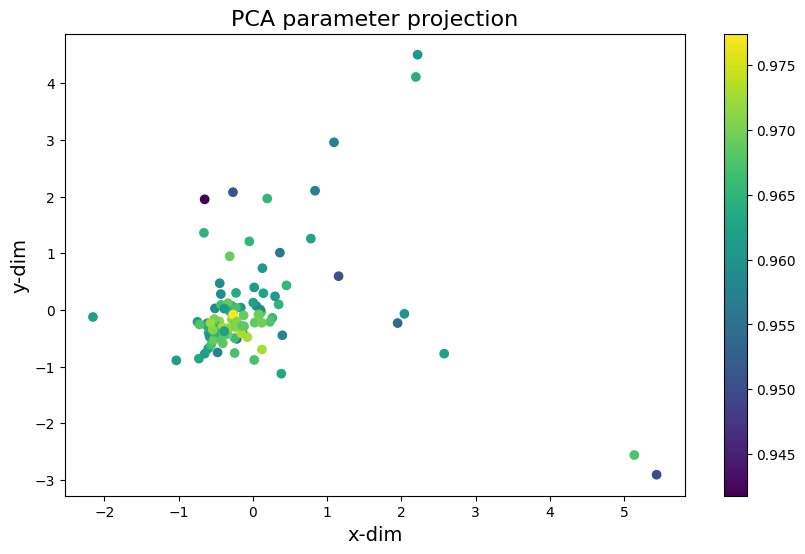

In [ ]:
pca = PCA(2)
params_projection = pca.fit_transform(np.array(flattened_params))
plot_params_projection(params_projection, 'PCA parameter projection')

In [ ]:
pca = PCA(50)
tsne = TSNE()
reduce_params = pca.fit_transform(np.array(flattened_params))
params_projection = tsne.fit_transform(reduce_params)

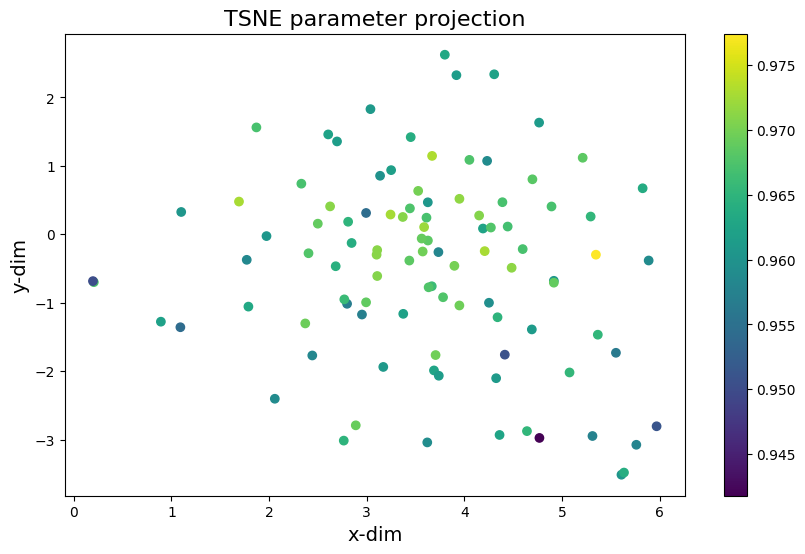

In [ ]:
plot_params_projection(params_projection, 'TSNE parameter projection')

## Conclusion

The results obtained are not clear enough to confirm or refute the hypothesis. One of the possible reasons may be the simplicity of the task: despite the attempt to introduce strong randomization into the architecture of the model, the output test quality for them does not differ much, and therefore there is not much difference between the architectures.

Thus, it might be worth taking a more complex dataset